# Models: Biased Generalized Matrix Factorization (Biased-GMF)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import SparseAdam, Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

from pytorch_common.util import set_device_name, \
                                get_device, \
                                LoggerBuilder

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

from torchviz import make_dot

<Figure size 432x288 with 0 Axes>

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
cpu = torch.device("cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.11.0'

In [9]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [10]:
set_seed(42)

## Carga de dataset

In [11]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191540 entries, 0 to 191539
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      191540 non-null  int64         
 1   user_seq                     191540 non-null  int64         
 2   user_movie_tags              191540 non-null  object        
 3   user_movie_rating            191540 non-null  int64         
 4   user_movie_rating_timestamp  191540 non-null  datetime64[ns]
 5   user_movie_rating_year       191540 non-null  int64         
 6   movie_id                     191540 non-null  int64         
 7   movie_seq                    191540 non-null  int64         
 8   movie_title                  191540 non-null  string        
 9   movie_genres                 191540 non-null  object        
 10  movie_for_adults             191540 non-null  bool          
 11  movie_original_language   

In [12]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-07-25 12:22:56,307 - INFO - Train: 83.74 % - Test: 7.71 %


## Definicion del modelo

In [13]:
params = Bunch({
    'lr': 0.001,
    'lr_factor': 0.1,
    'lr_patience': 3,
    'epochs': 50,
    'embedding_size': 50,
    'n_workers': 24,
    'batch_size': 64,
    'n_users': len(dataset.features_uniques[0]),
    'n_items': len(dataset.features_uniques[1]),
    'device': get_device()
})

In [14]:
train_dl = DataLoader(train_set, params.batch_size, num_workers=params.n_workers, pin_memory=True)
test_dl  = DataLoader(eval_set,  params.batch_size, num_workers=params.n_workers, pin_memory=True)

In [15]:
model = ml.BiasedGMF(
    n_users        = params.n_users,
    n_items        = params.n_items,
    embedding_size = params.embedding_size
).to(params.device)
model
# make_dot(y_pred, params=dict(model.named_parameters()))

BiasedGMF(
  (embedding): MultiFeatureEmbedding(
    (embedding): Embedding(31503, 50)
  )
  (embedding_bias): MultiFeatureEmbedding(
    (embedding): Embedding(31503, 1)
  )
  (dot): BatchDot()
)

## Entrenamiento del modelo

<Figure size 1440x360 with 1 Axes>

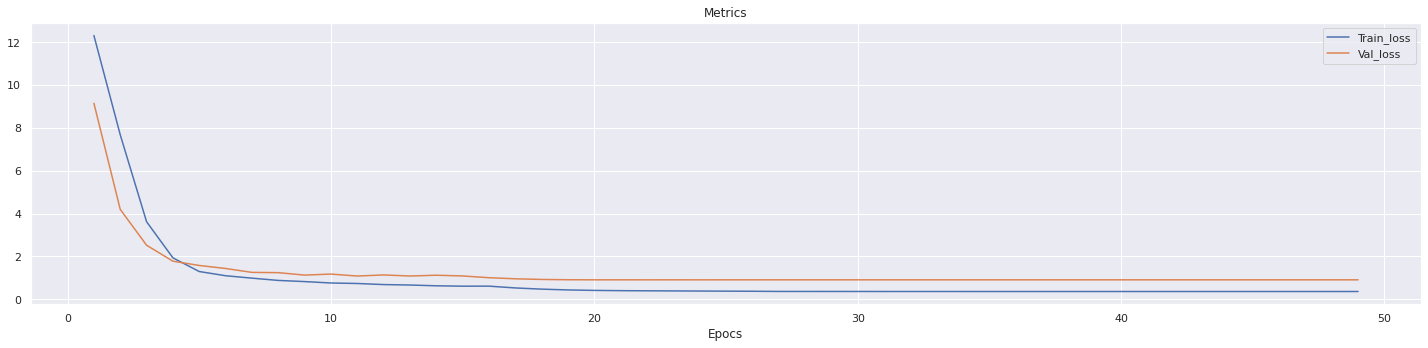

2022-07-23 16:34:35,985 - INFO - {'time': '0:00:09.40', 'epoch': 50, 'train_loss': 0.3648184133747634, 'val_loss': 0.9097431898117065, 'lr': 1.0000000000000004e-08}


In [22]:
result = model.fit(
    train_dl,
    epochs      = params.epochs,
    loss_fn     = ml.MSELossFn(),
    optimizer   = Adam(
        params       = model.parameters(),
        lr           = params.lr
    ),
    callbacks   = [
        Validation(
            test_dl,
            metrics = { 'val_loss': ml.MSELossFn(float_result=True)},
            each_n_epochs=1
        ),
        ReduceLROnPlateau(metric='val_loss', mode='min', factor=params.lr_factor, patience=params.lr_patience),
        MetricsPlotter(metrics=['train_loss', 'val_loss'], plot_each_n_epochs=2),
        Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
        SaveBestModel(metric='val_loss', path='../weights', experiment_name='gfm_bias')
    ]
)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

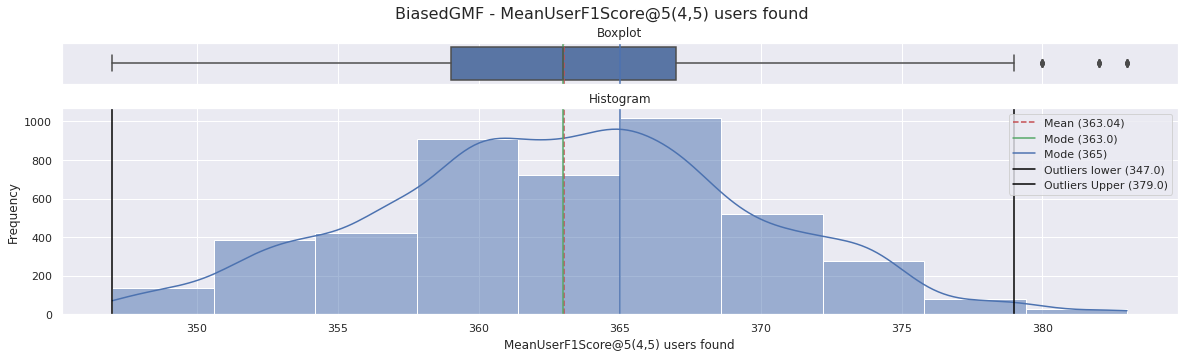


Metrics:



,"MeanUserF1Score@5(4,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

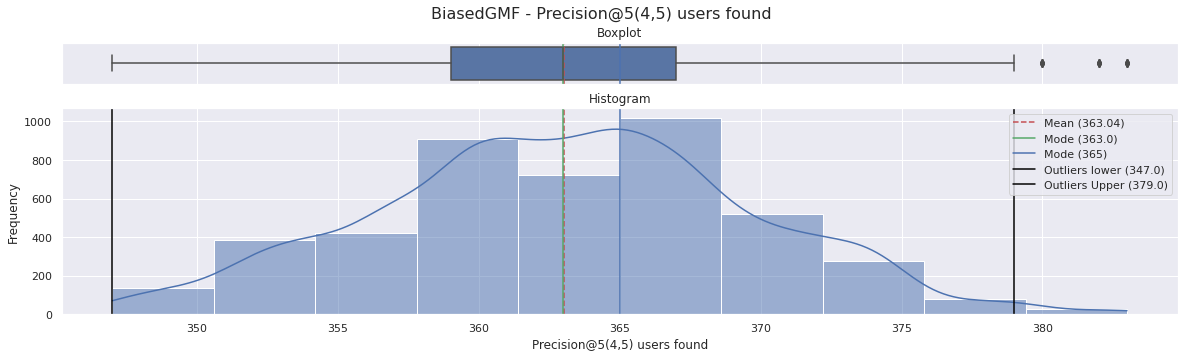


Metrics:



,"Precision@5(4,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

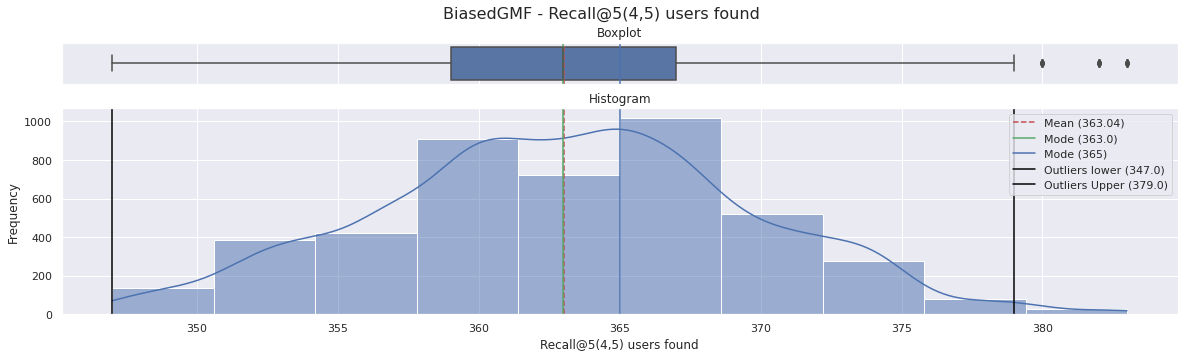


Metrics:



,"Recall@5(4,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

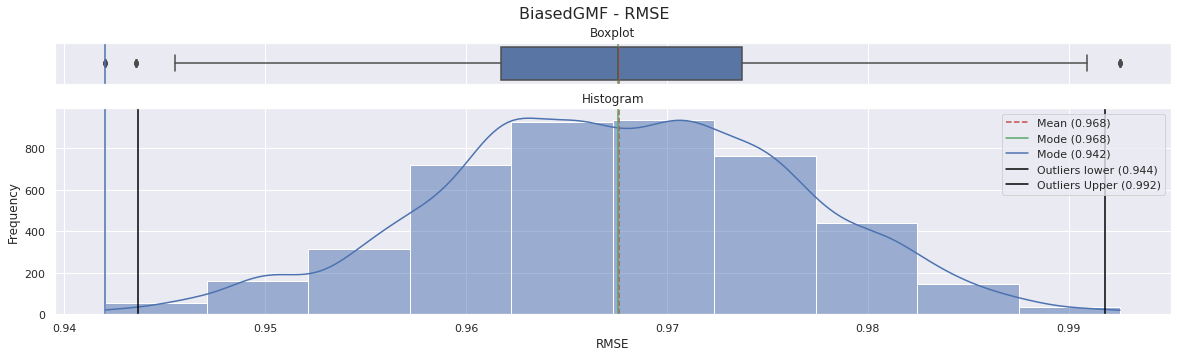


Metrics:



,RMSE
count,4500.000000
mean,0.967624
std,0.008866
min,0.942051
25%,0.961715
50%,0.967581
75%,0.973742
max,0.992547


<Figure size 1440x360 with 2 Axes>

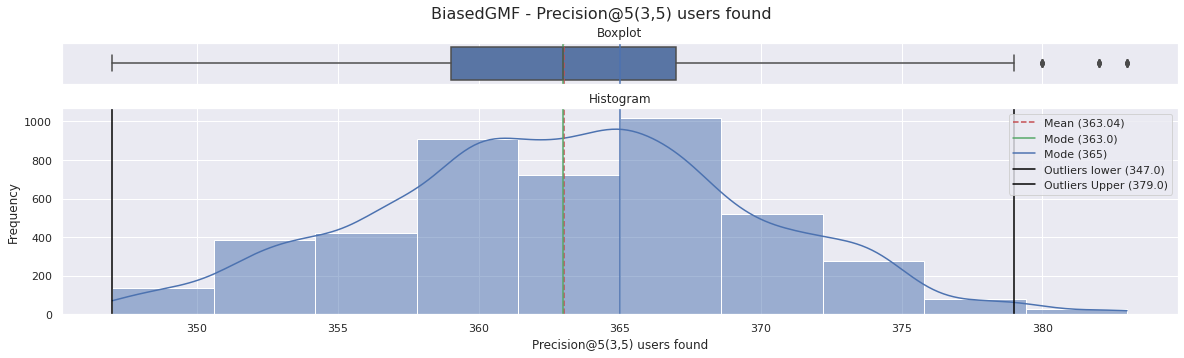


Metrics:



,"Precision@5(3,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

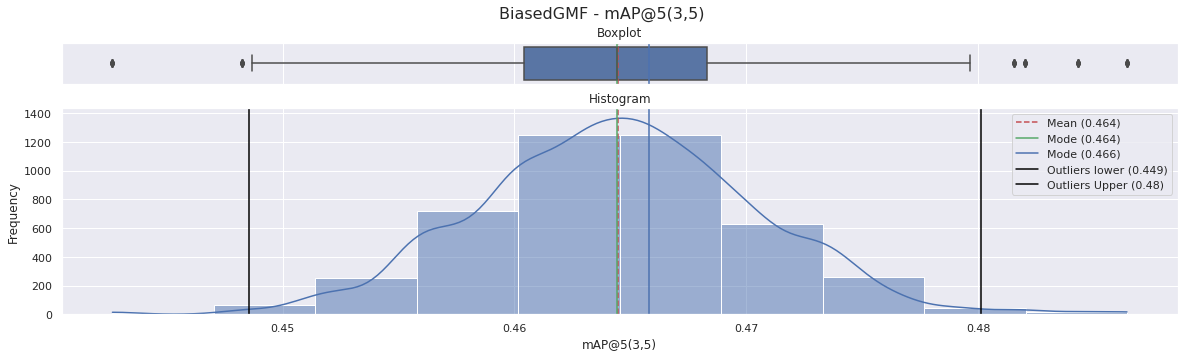


Metrics:



,"mAP@5(3,5)"
count,4500.000000
mean,0.464471
std,0.006010
min,0.442662
25%,0.460398
50%,0.464430
75%,0.468295
max,0.486424


<Figure size 1440x360 with 2 Axes>

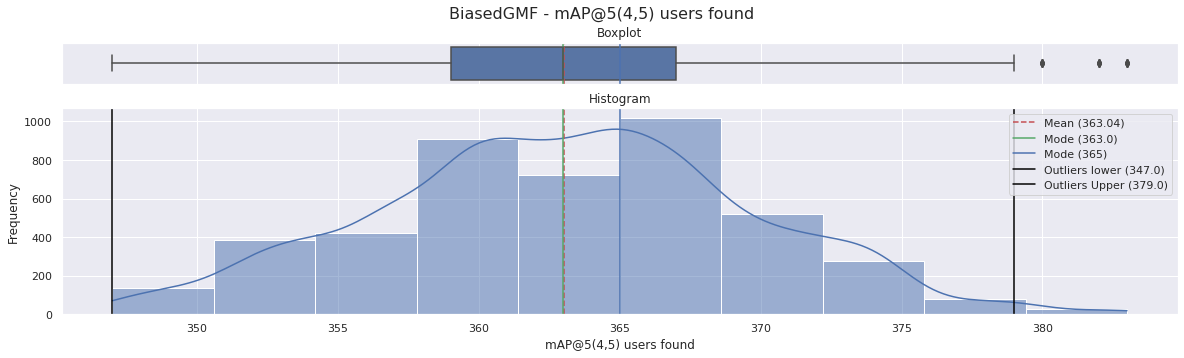


Metrics:



,"mAP@5(4,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

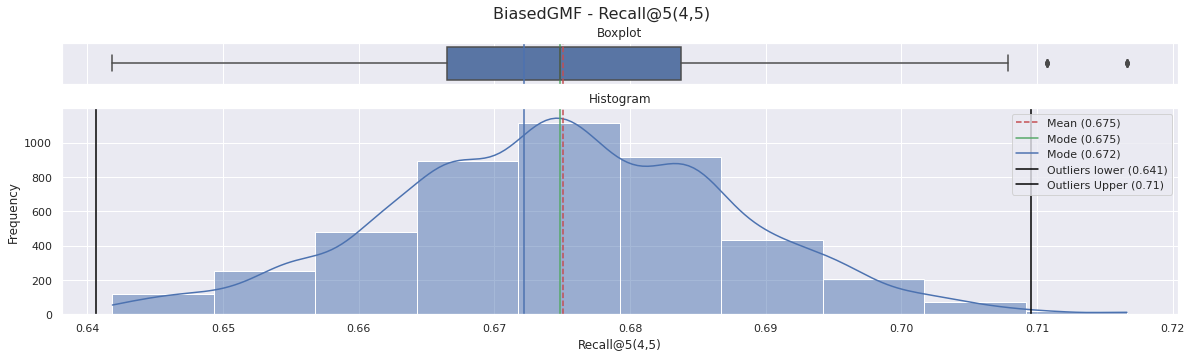


Metrics:



,"Recall@5(4,5)"
count,4500.000000
mean,0.675019
std,0.012627
min,0.641848
25%,0.666482
50%,0.674829
75%,0.683718
max,0.716621


<Figure size 1440x360 with 2 Axes>

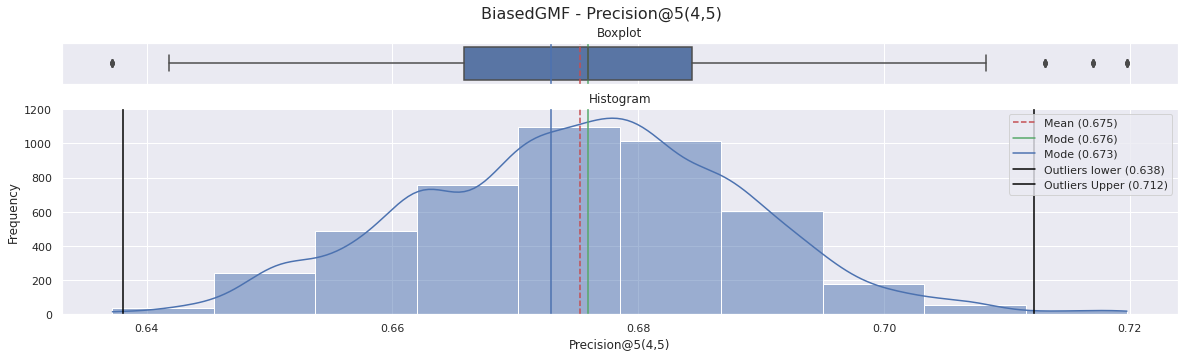


Metrics:



,"Precision@5(4,5)"
count,4500.000000
mean,0.675268
std,0.013296
min,0.637222
25%,0.665863
50%,0.675957
75%,0.684399
max,0.719774


<Figure size 1440x360 with 2 Axes>

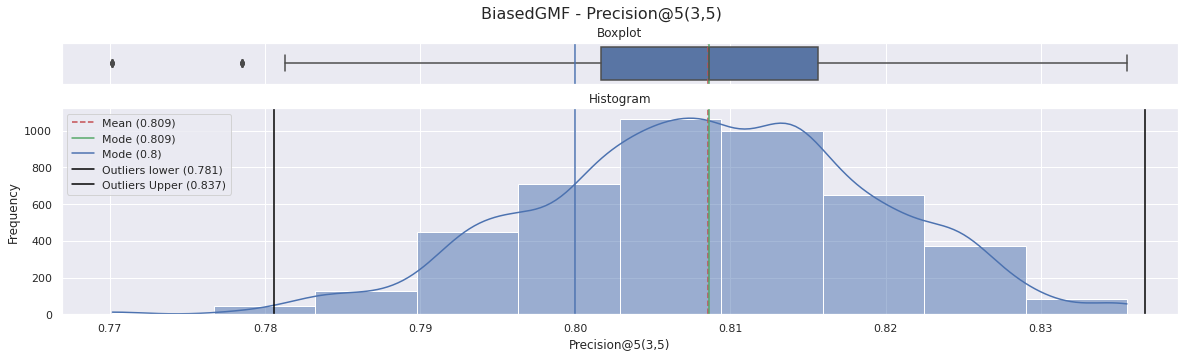


Metrics:



,"Precision@5(3,5)"
count,4500.000000
mean,0.808525
std,0.010724
min,0.770166
25%,0.801627
50%,0.808637
75%,0.815661
max,0.835556


<Figure size 1440x360 with 2 Axes>

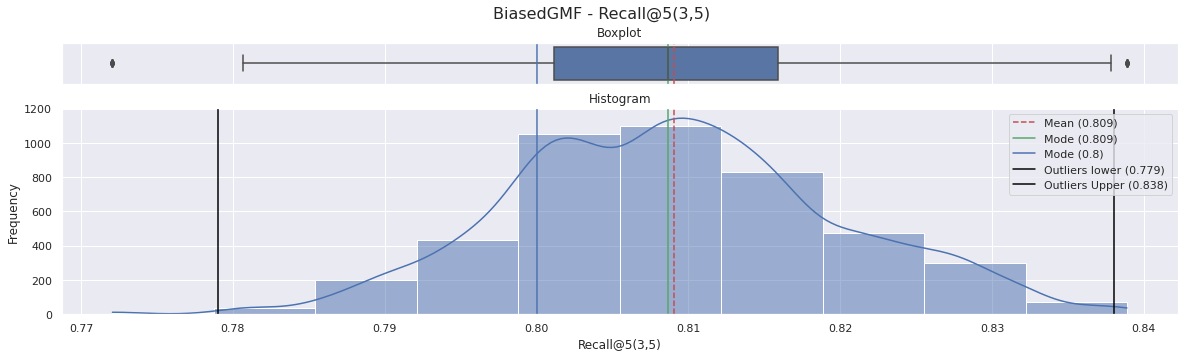


Metrics:



,"Recall@5(3,5)"
count,4500.000000
mean,0.809041
std,0.010836
min,0.772067
25%,0.801133
50%,0.808672
75%,0.815895
max,0.838889


<Figure size 1440x360 with 2 Axes>

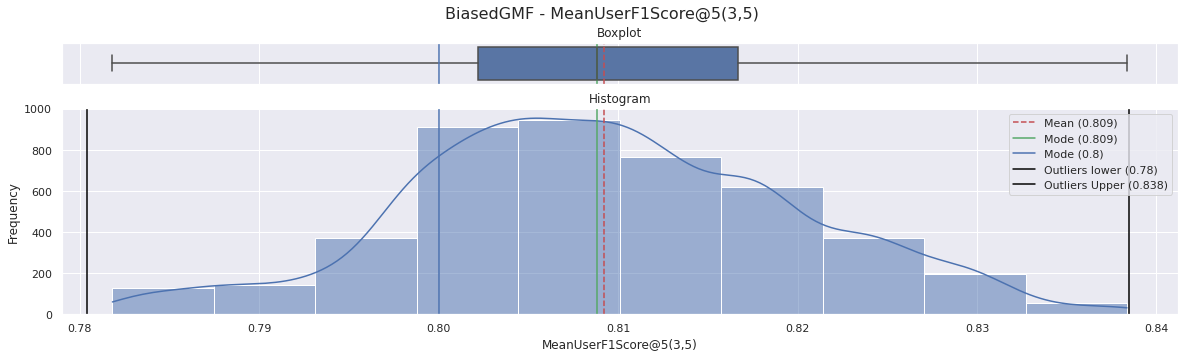


Metrics:



,"MeanUserF1Score@5(3,5)"
count,4500.000000
mean,0.809239
std,0.010681
min,0.781818
25%,0.802176
50%,0.808815
75%,0.816690
max,0.838356


<Figure size 1440x360 with 2 Axes>

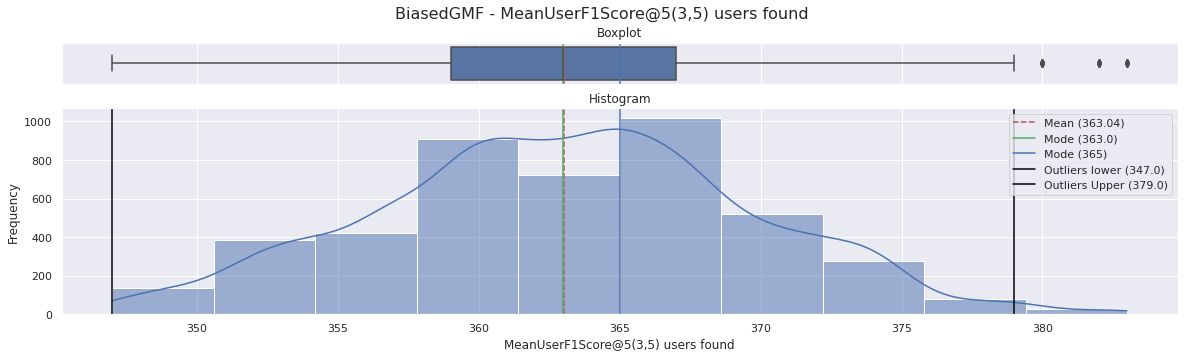


Metrics:



,"MeanUserF1Score@5(3,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

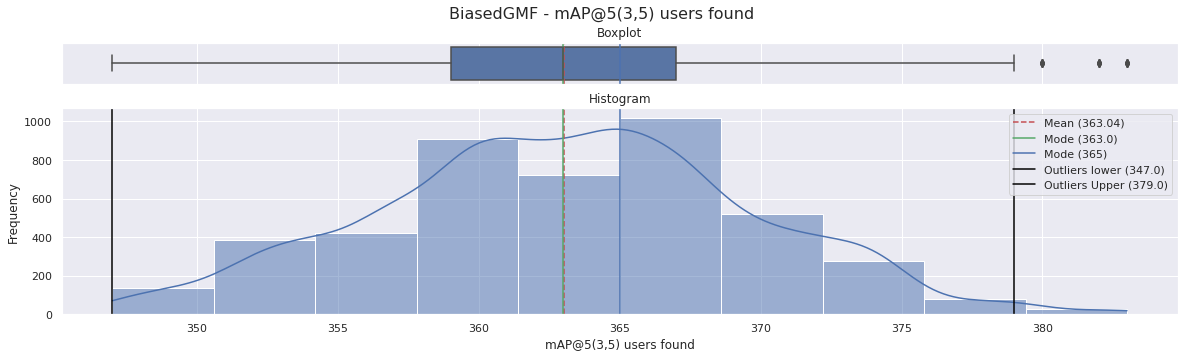


Metrics:



,"mAP@5(3,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


<Figure size 1440x360 with 2 Axes>

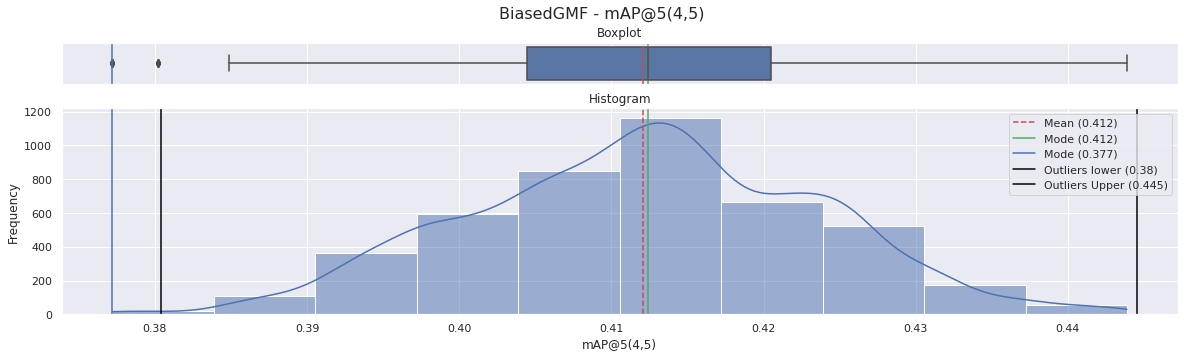


Metrics:



,"mAP@5(4,5)"
count,4500.000000
mean,0.412080
std,0.011446
min,0.377212
25%,0.404455
50%,0.412424
75%,0.420494
max,0.443886


<Figure size 1440x360 with 2 Axes>

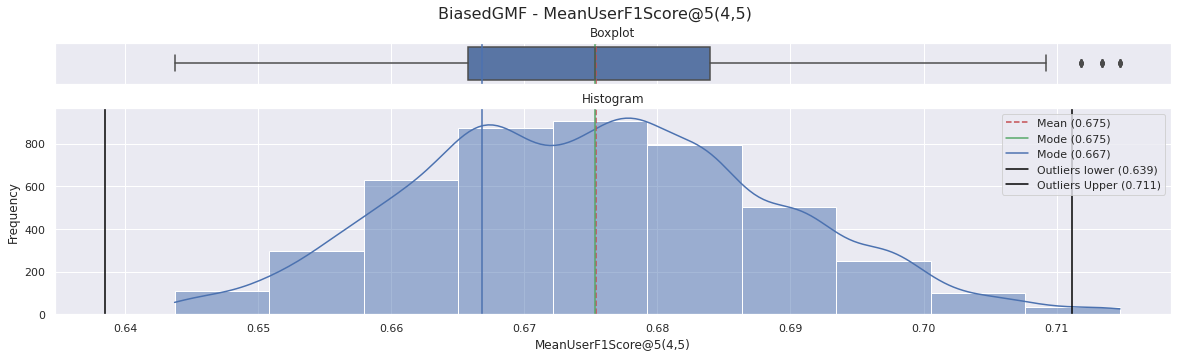


Metrics:



,"MeanUserF1Score@5(4,5)"
count,4500.000000
mean,0.675350
std,0.013288
min,0.643716
25%,0.665759
50%,0.675345
75%,0.683919
max,0.714763


<Figure size 1440x360 with 2 Axes>

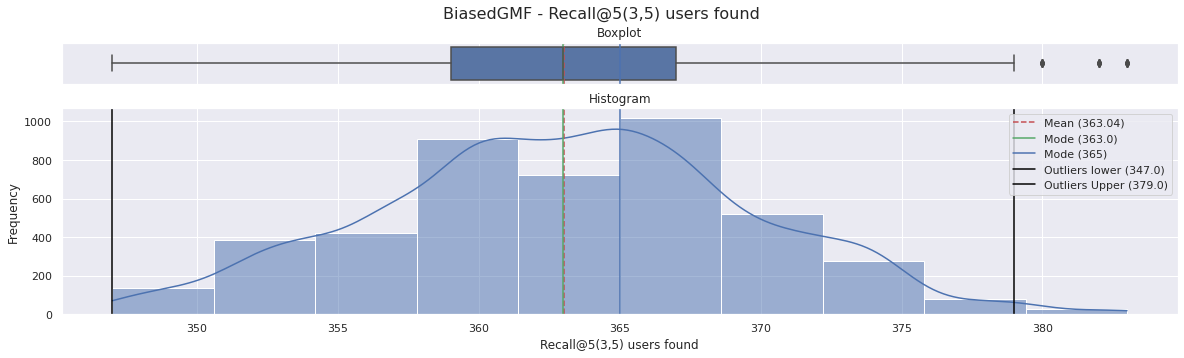


Metrics:



,"Recall@5(3,5) users found"
count,4500.000000
mean,363.040000
std,6.679844
min,347.000000
25%,359.000000
50%,363.000000
75%,367.000000
max,383.000000


In [16]:
PATH = '../weights/2022-07-23_16-23-41--gfm_bias--epoch_21--val_loss_0.9372825026512146.pt'
model.load_state_dict(torch.load(PATH))

deep_fm_predictor = ml.ModulePredictor(model)

validator = ml.Validator(
    n_samples  = 500,
    batch_size = 10000,
    metrics    = [
        mt.RMSE(),

        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserFBetaScoreAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserPrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanUserRecallAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserFBetaScoreAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserPrecisionAtk(user_index=0, k=5, discretizer=dr.between(3, 5)),
        mt.MeanUserRecallAtk(user_index=0, k=5, discretizer=dr.between(3, 5))
    ],
    predictors = [deep_fm_predictor]
)

summary = validator.validate(eval_set)
summary.save('../metrics/biased_gmf')


summary = ml.ValidatorSummary.load('../metrics/biased_gmf')
summary.plot(bins=10, show_table=True)